In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# General CBCP Equilibrium Solver

## (Special Case) Quartic Polynomial Latency Functions

In [2]:
x_temp = np.array([0, 1, 2, 3, 4])
x_temp[-2:]

array([3, 4])

In [3]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
# num_cols = arr.shape[1]
num_cols = 3
# arr[:, -num_cols:] - arr[:, -num_cols-1:-1]

np.linalg.norm(arr, axis=0)


array([12.56980509, 14.03566885, 15.55634919, 17.11724277, 18.70828693])

In [4]:
grad = np.array([0, 1, 2, 3, 4])

grad[2:]

array([2, 3, 4])

In [89]:
# Latency Function: a_4 x^4 + a_3 x^3 + a_2 x^2 + a_1 x + a_0

# def solve_CBCP_iter(v_ineligible_list, v_eligible_list, a = , num_iters = 1000, alpha_0 = ):
    
#     # TODO
    
#     return y_opt


def diff_vecs(arr):
    num_cols = arr.shape[1]
    diff_arr = arr[:, :num_cols - 1] - arr[:, 1:num_cols]
    
    return 

def solve_CBCP_iter_11(tau, B, v_I, v_E, a = np.array([0.5, 1.0]), input_flow = 1, \
                       num_iters_max = 5000, error_bound = 1E-3, diffs_num_cols = 10, \
                       y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0]) ):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # a = (a_0, a_1)
    
    print()    
    print("Starting solve_CBCP_iter_11:")
    print()
    
    # Initialize y_iters:
    y_iters = np.zeros((5, num_iters_max))
    
    y_el_var_current = y_init[0:3]
    y_in_var_current = y_init[3:]
    
    for k in range(num_iters_max):
        
        # y_el: \hat y_1 E, \tilde y_1 E, y_2 E
        y_el_var = cp.Variable(3)
        # y_in: y_1 I, y_2 I
        y_in_var = cp.Variable(2)
        
        # Compute gradient:
        
        grad = np.zeros(5)
        grad[0] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_E
        grad[1] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0]
        grad[2] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        grad[3] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_I
        grad[4] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        
        ## Apply Frank-Wolfe:
        # Compute next iterate:
        
#         objective = cp.Minimize(0.5 * a[1] * (y_el_var[0] + y_el_var[1] + y_in_var[0])**2 \
#                                 + a[0] * (y_el_var[0] + y_el_var[1] + y_in_var[0]) \
#                                 + y_in_var[0] * tau / v_I + y_el_var[0] * tau / v_E \
#                                 + 0.5 * a[1] * (y_el_var[2] + y_in_var[1])**2 \
#                                 + a[0] * (y_el_var[2] + y_in_var[1]) )
        
        objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

        constraints = []
        constraints += [y_el_var >= 0, y_in_var >= 0]
        constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
        constraints += [y_el_var[1] * tau <= B]
    
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        
#         print("grad:", grad)
#         print("y_el_var.value:", y_el_var.value)
#         print("y_in_var.value:", y_in_var.value)
#         print("y_el_var_current:", y_el_var_current)
#         print("y_in_var_current:", y_in_var_current)
        
        y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
        y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)
        
#         print("y_el_var_current (new):", y_el_var_current)
#         print("y_in_var_current (new):", y_in_var_current)
#         print()
        
        y_iters[0:3, k] = y_el_var_current
        y_iters[3:, k] = y_in_var_current
        
        if k >= diffs_num_cols + 1:
            diffs = np.linalg.norm(y_iters[:, -diffs_num_cols:] - y_iters[:, - diffs_num_cols - 1: -1], axis = 0)

            if np.max(diffs) < error_bound:
                break
                
        del y_el_var
        del y_in_var
    
    return y_el_var_current, y_in_var_current

def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([1, 0]), input_flow = 1):

    # y_el: \hat y_1, \tilde y_1, y_2
    y_el = cp.Variable(3)
    # y_in: y_1, y_2
    y_in = cp.Variable(2)
    
    objective = cp.Minimize(0.5 * a[1] * (y_el[0] + y_el[1] + y_in[0])**2 \
                            + a[0] * (y_el[0] + y_el[1] + y_in[0]) \
                            + y_in[0] * tau / v_I + y_el[0] * tau / v_E \
                            + 0.5 * a[1] * (y_el[2] + y_in[1])**2 \
                            + a[0] * (y_el[2] + y_in[1]) )
    
    constraints = []
    constraints += [y_el >= 0, y_in >= 0]
    constraints += [cp.sum(y_el) == 1, cp.sum(y_in) == 1]
    constraints += [y_el[1] * tau <= B]
    
    prob = cp.Problem(objective, constraints)
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    print("y_el.value:", y_el.value)
    print("y_in.value:", y_in.value)

    return y_el.value, y_in.value


In [99]:
def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, y_el, y_in, a):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # y_el = (\hat y_1 E, \tilde y_1 E, y_2 E)
    # y_in = (y_1 I, y_2 I)
    
    ell_1 = a[1] * (y_el[0] + y_el[1] + y_in[0]) + a[0]
    ell_2 = a[1] * (y_el[2] + y_in[1]) + a[0]
    
    obj_E = tau * y_el[0] + v_E * (ell_1 * (y_el[0] + y_el[1]) + ell_2 * y_el[2])
    obj_R = tau * (y_el[0] + y_in[0])
    obj_I = tau * y_in[0] + v_I * (ell_1 * (y_el[0] + y_el[1] + y_el[2]) + ell_2 * (y_in[0] + y_in[1]) )
    
    print()
    print("tau:", tau)
    print("y_el.shape:", y_el.shape)
    print("y_in.shape:", y_in.shape)
    print("ell_1:", ell_1)
    print("ell_2:", ell_2)
    print("obj_E.shape:", obj_E.shape)
    print("obj_R.shape:", obj_R.shape)
    print("obj_I.shape:", obj_I.shape)
    print()

    return lambda_E * obj_E - lambda_R * obj_R + lambda_I * obj_I

    

In [100]:
def proj_tau_B_11(tau, B):
    if tau <= B and tau >= 0 and B >= 0:
        return tau, B
    elif tau > 1 and 0 < B <= 1:
        return 1.0, B
    elif tau > 1 and B <= 0:
        return 1.0, 0.0
    elif 0 < tau <= 1 and B < 0:
        return tau, 0.0
    elif tau <= 0 and B + tau < 0:
        return 0.0, 0.0
    elif B + tau >= 0 and B + tau < 2:
        return (B + tau)/2, (B + tau)/2
    elif B + tau >= 2 and B > 1:
        return 1.0, 1.0
    else:
        assert 1 == 0, "This case should not happen!"

In [23]:
# arr_temp = np.zeros(5)
# arr_temp[0] = 1

## Grid Search:

In [92]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.5, 1.0])
input_flow = 1
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0


grid_size = 0.05
tau_arr = (np.arange(int(1/grid_size)) + 1) * grid_size
B_arr = (np.arange(int(1/grid_size)) + 1) * grid_size

welfare_obj_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0]))
y_el_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 3))
y_in_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 2))
welfare_obj_list = []

for tau_index, tau in enumerate(tau_arr):
    for B_index, B in enumerate(B_arr):
        if B < tau:
            print("tau:", tau)
            print("B:", B)
            y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
                = solve_CBCP_iter_11(tau = tau, B = B, v_I = v_I, v_E = v_E, a = a, input_flow = input_flow, \
                                     num_iters_max = num_iters_max, error_bound = error_bound, diffs_num_cols = diffs_num_cols, \
                                     y_init = y_init)
            
            welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, \
                                                              y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
                                                              a = a)
            welfare_obj_list.append(welfare_obj_arr[tau_index][B_index])
            
            print()

time_2 = time.time()

print("Time:", time_2 - time_1)



tau: 0.1
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.06428571428571428
obj_I: 3.0428571428571427

tau: 0.15000000000000002
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.10714285714285716
obj_I: 3.0642857142857145

tau: 0.15000000000000002
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.08571428571428573
obj_I: 3.0642857142857145

tau: 0.2
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.15000000000000002
obj_I: 3.085714285714286

tau: 0.2
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.12857142857142856
obj_I: 3.085714285714286

tau: 0.2
B: 0.15000000000000002

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.10714285714285712
obj_I: 3.085714285714286

tau: 0.25
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.15
obj_I: 3.107142857142857

tau: 0.25
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.1392857142857143
obj_I: 3.107142857142857

tau: 0.25
B: 0.1500000000000000

obj_E.shape: ()
obj_R: 0.1321428571428572
obj_I: 3.1285714285714286

tau: 0.65
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.3214285714285714
obj_I: 3.2785714285714285

tau: 0.65
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.31785714285714284
obj_I: 3.2785714285714285

tau: 0.65
B: 0.15000000000000002

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.3142857142857143
obj_I: 3.278571428571428

tau: 0.65
B: 0.2

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.33392857142857146
obj_I: 3.3017857142857143

tau: 0.65
B: 0.25

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.3303571428571429
obj_I: 3.3017857142857143

tau: 0.65
B: 0.30000000000000004

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.16428571428571437
obj_I: 3.1392857142857142

tau: 0.65
B: 0.35000000000000003

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.3232142857142858
obj_I: 3.3017857142857143

tau: 0.65
B: 0.4

Starting solve_CBCP_iter_11:

obj_E.shape:

obj_E.shape: ()
obj_R: 0.06785714285714287
obj_I: 3.060714285714286

tau: 0.8500000000000001
B: 0.8

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.0642857142857143
obj_I: 3.060714285714286

tau: 0.9
B: 0.05

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.5107142857142857
obj_I: 3.45

tau: 0.9
B: 0.1

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.5071428571428571
obj_I: 3.4499999999999997

tau: 0.9
B: 0.15000000000000002

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.5035714285714286
obj_I: 3.45

tau: 0.9
B: 0.2

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.275
obj_I: 3.225

tau: 0.9
B: 0.25

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.2714285714285714
obj_I: 3.225

tau: 0.9
B: 0.30000000000000004

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.26785714285714285
obj_I: 3.225

tau: 0.9
B: 0.35000000000000003

Starting solve_CBCP_iter_11:

obj_E.shape: ()
obj_R: 0.29642857142857143
obj_I: 3.2571428571428576

tau: 0.9
B: 0.4



In [115]:
# welfare_obj_arr

argmin_indices_wrapped = np.where(welfare_obj_arr == min(welfare_obj_list))
argmin_indices = [argmin_indices_wrapped[0][0], argmin_indices_wrapped[1][0]]
# argmin_indices
argmin_tau = tau_arr[argmin_indices[0]]
argmin_B = B_arr[argmin_indices[1]]

print("argmin_tau:\n", np.round(argmin_tau, 2))
print("\nargmin_B:\n", np.round(argmin_B, 2))

welfare_obj_arr[argmin_indices[0], argmin_indices[1] ]


argmin_tau:
 0.85

argmin_B:
 0.7


3.84491914412824

In [112]:
# welfare_obj_arr

In [11]:
# # lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower' ) 
# plt.colorbar() 
# plt.xlabel("Toll") 
# plt.ylabel("Budget")

Text(0, 0.5, 'Budget')

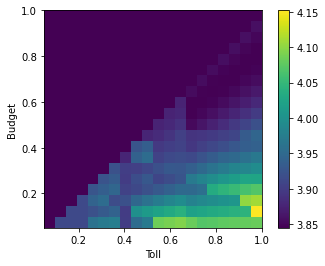

In [12]:
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 
plt.imshow(welfare_obj_arr.T, extent=[np.min(tau_arr), np.max(tau_arr), np.min(B_arr), np.max(B_arr)], \
           vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 

plt.colorbar() 
plt.xlabel("Toll")
plt.ylabel("Budget")
# plt.xticks(x_positions, x_labels)

## Chinmay's Algorithm:

## (To edit, below)

In [104]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.5, 1.0])
input_flow = 1
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.05, 0.95, 0.95, 0.05])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0

tau_max, B_max = 1.0, 1.0
d = 2
num_iters = 1000
tau = np.zeros(num_iters)
tau_perturbed = np.zeros(num_iters)
B = np.zeros(num_iters)
B_perturbed = np.zeros(num_iters)
delta = np.zeros(num_iters)
eta = np.zeros(num_iters)
eta_bar = 1.0
delta_bar = 1.0

B[0] = 0.4
tau[0] = 0.5

for i in range(num_iters+1):
    eta[i] = eta_bar * (i+1)**(-1/2) * d**(-1)
    delta[i] = delta_bar * (i+1)**(-1/4) * d**(-1/2)
    w_i_unnormalized = np.random.randn(2)
    w_i = w_i_unnormalized / np.linalg.norm(w_i_unnormalized)
    print("w_i:", w_i)
    tau_perturbed[i] = tau[i] + delta[i] * w_i[0]
    B_perturbed[i] = B[i] + delta[i] * w_i[1]
    
    if tau_perturbed[i] > B_perturbed[i] or tau_perturbed[i] < 0 or B_perturbed[i] < 0:
        tau_perturbed[i], B_perturbed[i] = proj_tau_B_11(tau_perturbed[i], B_perturbed[i])
    
    # TODO
#     if B_perturbed[i] <= tau_perturbed[i] and B_perturbed[i] >= 0 and tau_perturbed[i] >= 0:        
    
    print()
    print("New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):")
    print()
    y_el, y_in = solve_CBCP_iter_11(tau = tau[i], B = B[i], v_I = v_I, v_E = v_E, a = a, input_flow = input_flow, \
                                     num_iters_max = num_iters_max, error_bound = error_bound, diffs_num_cols = diffs_num_cols, \
                                     y_init = y_init)
    
    print("tau_perturbed[i]:", tau_perturbed[i])
    print("B_perturbed[i]:", B_perturbed[i])
    print()
    print("New solve_CBCP_iter_11 call to solve_CBCP (perturbed):")
    print()
    y_el_perturbed, y_in_perturbed = solve_CBCP_iter_11(tau = tau_perturbed[i], B = B_perturbed[i], v_I = v_I, v_E = v_E, a = a, input_flow = input_flow, \
                                                        num_iters_max = num_iters_max, error_bound = error_bound, diffs_num_cols = diffs_num_cols, \
                                                        y_init = y_init)
    
    print("y_el:", y_el)
    print("y_in:", y_in)
    print("y_el_perturbed:", y_el_perturbed)
    print("y_in_perturbed:", y_in_perturbed)
    
    welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[i], v_I = v_I, v_E = v_E, \
                          y_el = y_el, y_in = y_in, a = a)
    welfare_perturbed = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau_perturbed[i], v_I = v_I, v_E = v_E, \
                                    y_el = y_el_perturbed, y_in = y_in_perturbed, a = a)
    
    print("welfare:", welfare)
    print("welfare_perturbed:", welfare_perturbed)
    print("tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):\n", tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare))
    
    tau[i+1] = tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare)
    B[i+1] = B[i] - eta[i] * (d/delta[i]) * w_i[1] * (welfare_perturbed - welfare)

    if tau[i+1] > B[i+1] or tau[i+1] < 0 or B[i+1] < 0:
        tau[i+1], B[i+1] = proj_tau_B_11(tau[i+1], B[i+1])

time_2 = time.time()

print("Time:", time_2 - time_1)



w_i: [0.49753297 0.86744507]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8518089383487871
B_perturbed[i]: 1.0133762881770858

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.01428571 0.34285714 0.64285714]
y_in: [0.42857143 0.57142857]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.5
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.2857142857142856
ell_2: 1.7142857142857144
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8518089383487871
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.9367346938775514
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.5473865100633061
w_i: [-0.99527542  0.0970919 ]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Start

y_el: [0.         0.67857143 0.32142857]
y_in: [0.21428571 0.78571429]
y_el_perturbed: [0.02338766 0.57649096 0.40012138]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.618354331253421
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.392857142857143
ell_2: 1.6071428571428572
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.1713071909815254
ell_2: 1.8286928090184746
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.877040816326531
welfare_perturbed: 3.860604739173903
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.6314219271963802
w_i: [ 0.01916584 -0.99981632]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.4660891330655198
B_perturbed[i]: 0.4660891330655198

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.67857143 0.32142857]
y_in: [0.21428571 0.78571429]
y_el_perturbed: [0.       

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01598836 0.66528251 0.31872913]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.6995078799551508
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.252699445059807
ell_2: 1.747300554940193
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.846205934827802
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.7148030946110911
w_i: [-0.69193102  0.72196362]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.4775714109662894
B_perturbed[i]: 0.9503355761463522

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.       

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.7313362614161765
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9151529868728544
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.7313362614161765
w_i: [0.95794936 0.28693731]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8187686866194878

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.0129450

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.67857143 0.32142857]
y_in_perturbed: [0.21428571 0.78571429]

tau: 0.7532407880565678
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.4910049114798643
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.392857142857143
ell_2: 1.6071428571428572
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.877040816326531
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.7572546024939666
w_i: [0.74536802 0.66665322]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.955432153755682
B_perturbed[i]: 0.955432153755682

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbe

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.67857143 0.32142857]
y_in_perturbed: [0.21428571 0.78571429]

tau: 0.7622134157900037
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.5875783646115638
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.392857142857143
ell_2: 1.6071428571428572
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.877040816326531
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.7637681839495577
w_i: [-0.48906906  0.87224507]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.6316901098797274
B_perturbed[i]: 1.0057334465342482

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pertu

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01746053 0.64761652 0.33492296]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.7785897663383581
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.2365056153367968
ell_2: 1.7634943846632032
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.847803751072058
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.7897542914362554
w_i: [ 0.98531469 -0.17074823]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.7395386681372587

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01860438 0.63389029

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.67857143 0.32142857]
y_in_perturbed: [0.21428571 0.78571429]

tau: 0.7999792372630679
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.6081902320597483
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.392857142857143
ell_2: 1.6071428571428572
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.877040816326531
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.802914783261078
w_i: [0.48266295 0.87580619]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9228732302306032
B_perturbed[i]: 1.0207788179084984

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturb

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.8127447642729007
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.7232167438433292
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.8127447642729007
w_i: [-0.99384343  0.11079368]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.573140224247242
B_perturbed[i]: 0.8394558812656844

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_per

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.8322783040213839
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9520965311783627
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.832278304021384
w_i: [0.73164246 0.68168858]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9914996154134076

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [6.0717032

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01056078 0.73041348 0.25902574]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.8487680812893438
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3124028301040211
ell_2: 1.6875971698959789
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.845752693265645
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.8595303324537941
w_i: [-0.95307792  0.30272509]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.637792146059569
B_perturbed[i]: 0.922975753947142

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.      

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.8645349925123609
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.7553519180085151
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.8645349925123609
w_i: [ 0.93540436 -0.35357981]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.7862435812592661

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01526

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.8783999754034084
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.7864195417203362
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.8783999754034084
w_i: [ 0.07445217 -0.99722459]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.7785556471530661
B_perturbed[i]: 0.7785556471530661

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_per

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.882710550212531
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9850381272977731
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.882710550212531
w_i: [-0.89623063 -0.44358839]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.6924150550564661
B_perturbed[i]: 0.7885239999164313

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.8947403759830692
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.7525711452320754
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.8947403759830692
w_i: [-0.34866357 -0.93724795]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.7608642359699581
B_perturbed[i]: 0.7608642359699581

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pe

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.8991762683701429
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.8991762683701429
w_i: [-0.45064109  0.89270522]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8070291448726828
B_perturbed[i]: 1.0817166971290848

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.     

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9037375580934266
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8931676060819114
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9037375580934266
w_i: [0.6007599  0.79942951]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0247207499499025
B_perturbed[i]: 1.06472955345627

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pertur

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9074495691839475
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8157487286899829
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9074495691839475
w_i: [-0.25206704  0.96770977]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8574121845295996
B_perturbed[i]: 1.0995479305744285

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9118765362139957
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8565097097404999
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9118765362139957
w_i: [-0.07490416 -0.99719074]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8069039240348843
B_perturbed[i]: 0.8069039240348843

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

tau_perturbed[i]: 0.7733600443586154
B_perturbed[i]: 1.0459939494834294

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9198537234525197
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.7733600443586154
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9198537234525197
w_i: [-0.49273998 -0.8701766 ]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.7882990884411225
B_perturbed[i]: 0.7882990884411225

New sol

tau_perturbed[i]: 0.77261602167564
B_perturbed[i]: 0.7957088181944668

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9186979342963989
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.77261602167564
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9186979342963989
w_i: [ 0.38415357 -0.92326921]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.867291025532868
B_perturbed[i]: 0.867291025532868

New solve_CBC

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9160251590983761
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8469948430852423
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9160251590983761
w_i: [-0.99994053  0.01090623]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.7275331800404506
B_perturbed[i]: 0.9180810182281948

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pe

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01552893 0.67079568 0.31367539]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9193584800130733
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.2577531805508677
ell_2: 1.7422468194491323
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8458361472660254
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9253412169396972
w_i: [-0.2448286  -0.96956638]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8059351147563083
B_perturbed[i]: 0.8059351147563083

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.    

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01753003 0.64678246 0.33568751]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9189908238395619
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.2357410630428594
ell_2: 1.7642589369571406
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.847894746764675
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9226048832583321
w_i: [ 0.99078607 -0.13543616]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8922833686175329

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00769405 0.76481432 

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9248432316699176
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.7440083533544495
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9248432316699177
w_i: [ 0.27568933 -0.96124679]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8623300279779913
B_perturbed[i]: 0.8623300279779913

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_per

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9376468228182735

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.0044538  0.80369728 0.19184892]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9330696728509171
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3795796465000718
ell_2: 1.620420353499928
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8554708063302083
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.938094863432768
w_i: [-0.98752115 -0.15748643]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.7574887562180884
B_perturbed[i]: 0.907234076254498

New solve_CBCP_iter_11 call to solve_CB

tau_perturbed[i]: 0.9455945083624755
B_perturbed[i]: 1.117239950778381

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9384706292233795
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9455945083624755
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9384706292233795
w_i: [ 0.08658146 -0.99624477]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8571793113845687
B_perturbed[i]: 0.8571793113845687

New sol

tau_perturbed[i]: 0.763481170595236
B_perturbed[i]: 0.9597595031379823

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.939434854612424
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.763481170595236
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.939434854612424
w_i: [0.9778068 0.2095086]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9765073488205293

New solve_CBCP_iter_11 call 

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.7856653351931624

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01530962 0.67342743 0.31126295]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9409102163894647
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.2601656205089133
ell_2: 1.7398343794910867
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.845681240336205
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9447829930964087
w_i: [0.93563125 0.35297898]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 1.0

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting so

tau_perturbed[i]: 1.019009632709916
B_perturbed[i]: 1.0952718879965588

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9403115284037671
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.019009632709916
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9403115284037671
w_i: [-0.42856386 -0.90351149]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8246602000020553
B_perturbed[i]: 0.8246602000020553

New solve

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8530831582576367

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01049406 0.73121414 0.2582918 ]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9404058432461562
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3131367672024288
ell_2: 1.6868632327975712
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.845800350172835
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.947410038070014
w_i: [0.92488984 0.38023516]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 1.0

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solv

tau_perturbed[i]: 0.8740641280114272
B_perturbed[i]: 0.8740641280114272

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9432358839333479
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8740641280114272
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9432358839333479
w_i: [ 0.0651903  -0.99787285]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8636688160342231
B_perturbed[i]: 0.8636688160342231

New sol

tau_perturbed[i]: 0.8800390720802591
B_perturbed[i]: 0.8800390720802591

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9401862553615513
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8800390720802591
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9401862553615513
w_i: [0.19961019 0.97987539]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9739610520091436
B_perturbed[i]: 1.1059848676208441

New solv

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8668288395605303

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00951223 0.74299615 0.24749163]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9425567590285866
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3239369453689882
ell_2: 1.676063054631012
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.846651125236969
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9493818322588409
w_i: [-0.99010664  0.14031694]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.7779312945306764
B_perturbed[i]: 0.9678176671073905

New solve_CBCP_iter_11 call to solve_C

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9449828616266414
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0454960488407046
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9449828616266414
w_i: [-0.60197636  0.79851391]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8445759045558289
B_perturbed[i]: 1.078171401582273

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pertu

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9462694349509371
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.7867475995347207
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.946269434950937
w_i: [-0.81122659  0.58473192]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8118869530246211
B_perturbed[i]: 1.0431322944417964

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01450178 0.68312148 0.30237674]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9480041227439885
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.2690518348384983
ell_2: 1.730948165161502
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8452311239066996
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9511599593265243
w_i: [ 0.94928903 -0.31440475]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8942364223986344

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00755454 0.76648836 

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.947727036323307
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9477270363233069
w_i: [ 0.74013471 -0.67245863]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8379491395919993

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01157506 0.71824212 

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9518382689746105
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9487137267636773
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9518382689746105
w_i: [ 0.75691028 -0.65351881]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8458968102395483

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01100

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9514730636617494
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8881893247766555
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9514730636617494
w_i: [0.70060684 0.71354752]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0642768398696967
B_perturbed[i]: 1.0663604016998813

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pertu

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00774146 0.76424528 0.22801325]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9514730636617494
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3434153193715974
ell_2: 1.6565846806284026
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8488932503258204
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9575573193964112
w_i: [ 0.99958839 -0.02868878]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9486999114728475

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00366429 0.81317135

tau_perturbed[i]: 0.8886157709564364
B_perturbed[i]: 0.8886157709564364

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9566527910161111
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8886157709564364
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9566527910161111
w_i: [-0.92827012 -0.37190668]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8091372219671347
B_perturbed[i]: 0.8975514331470914

New sol

tau_perturbed[i]: 0.8786959836279238
B_perturbed[i]: 0.8786959836279238

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9567607903290501
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8786959836279238
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9567607903290501
w_i: [-0.94623225  0.32348807]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.807334768718684
B_perturbed[i]: 1.0078450096965736

New solv

tau_perturbed[i]: 0.835666496241684
B_perturbed[i]: 0.8566138390238694

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9567607903290498
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.835666496241684
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9567607903290497
w_i: [0.11306608 0.99358747]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9745172711642687
B_perturbed[i]: 1.1127988900729848

New solve_

tau_perturbed[i]: 0.8436131055599038
B_perturbed[i]: 0.8489452076487921

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9567607903290496
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8436131055599038
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9567607903290496
w_i: [-0.98189808 -0.18941005]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8033912595612103
B_perturbed[i]: 0.9271755092628494

New sol

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8627594188424668

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.0098029  0.73950807 0.25068903]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9597236411314941
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3207395433762237
ell_2: 1.679260456623776
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.846370081592816
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9653123715212423
w_i: [-0.65185284  0.75834549]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8590658552015513
B_perturbed[i]: 1.0780426440415303

New solve_CBCP_iter_11 call to solve_C

tau_perturbed[i]: 0.8117078708666923
B_perturbed[i]: 0.9991270148949701

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9615455562511432
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8117078708666923
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9615455562511432
w_i: [0.91290929 0.4081625 ]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 1.0

New solve_CBCP_iter_11 call to solve_

tau_perturbed[i]: 0.8140160634783579
B_perturbed[i]: 0.9184430235496719

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9615455562511431
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8140160634783579
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9615455562511432
w_i: [ 0.46503911 -0.88529014]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8255549081953178

New solve_CBCP_iter_1

tau_perturbed[i]: 0.8102672905233885
B_perturbed[i]: 0.9622229446657006

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9631988474370299
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8102672905233885
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.96319884743703
w_i: [-0.99999932  0.00116886]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8103478292664557
B_perturbed[i]: 0.9633775091807542

New solv

tau_perturbed[i]: 1.0371973864585227
B_perturbed[i]: 1.0984288309385912

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9646447806272779
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0371973864585227
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.964644780627278
w_i: [ 0.89755761 -0.44089719]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8975802157494142

New solve_CBCP_iter_11

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8522551505882758

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.0105532  0.73050441 0.25894238]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9681986458655482
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.312486189747931
ell_2: 1.687513810252069
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.845758040998378
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.972798755463231
w_i: [0.54437467 0.83884219]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0501260013124893
B_perturbed[i]: 1.0946806286654585

New solve_CBCP_iter_11 call to solve_CBCP

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9676365099667529
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8256452234236583
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.967636509966753
w_i: [-0.7673499   0.64122862]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8520733593676199
B_perturbed[i]: 1.0642057535432035

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

tau_perturbed[i]: 0.9032968522807843
B_perturbed[i]: 0.9032968522807843

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9661012636668875
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9032968522807843
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9661012636668875
w_i: [0.99123761 0.13209089]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9858931623065027

New solve_CBCP_iter_11 

tau_perturbed[i]: 0.9919558307419474
B_perturbed[i]: 1.1141378121735501

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9670016244212714
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9919558307419474
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9670016244212714
w_i: [0.6306804  0.77604267]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0610760323799884
B_perturbed[i]: 1.0827587569951052

New solve

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9014167177511392

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00704166 0.7726429  0.22031544]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9670016244212714
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3511131353758952
ell_2: 1.648886864624105
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.850030370628148
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9721630682557997
w_i: [-0.04525949  0.99897526]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9615914847259699
B_perturbed[i]: 1.11666669046087

New solve_CBCP_iter_11 call to solve_CBC

tau_perturbed[i]: 1.0
B_perturbed[i]: 1.0

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9727178344778895
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9727178344778894
w_i: [-0.52765579 -0.84945828]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8709543194283225
B_perturbed[i]: 0.8709543194283225

New solve_CBCP_iter_11 call to solve_CBCP (perturbe

tau_perturbed[i]: 0.8341020559414042
B_perturbed[i]: 1.0201410400592668

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9737699792998301
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8341020559414042
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9737699792998302
w_i: [ 0.94525578 -0.32633037]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9257682174200954

New solve_CBCP_iter_1

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8348149358830808

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01179893 0.71555566 0.27264541]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.971418683326483
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.2987831639081349
ell_2: 1.7012168360918651
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8451029138763686
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9739871287561451
w_i: [-0.41691438  0.90894576]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9083430282397152
B_perturbed[i]: 1.102468709342519

New solve_CBCP_iter_11 call to solve_C

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8888493992418938

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00793933 0.76187091 0.23018976]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9693855057238188
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3412388136900595
ell_2: 1.6587611863099405
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8485975270319925
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9744431916120353
w_i: [ 0.92223294 -0.38663472]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9138626455231007

New solve_CBCP_iter_11 call to solve_CBCP (perturbe

tau_perturbed[i]: 0.9093689410947818
B_perturbed[i]: 0.9093689410947818

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9737398357322053
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9093689410947818
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9737398357322053
w_i: [-0.16290853 -0.98664118]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8903034153104503
B_perturbed[i]: 0.8903034153104503

New sol

tau_perturbed[i]: 0.8394518974101784
B_perturbed[i]: 1.030846845246367

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9711357383411334
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8394518974101784
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9711357383411334
w_i: [-0.84286615  0.53812327]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8493195633235036
B_perturbed[i]: 1.048908607397714

New solve

tau_perturbed[i]: 0.8913768437654854
B_perturbed[i]: 0.8913768437654854

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9719802845149251
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8913768437654854
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9719802845149251
w_i: [ 0.41298154 -0.9107394 ]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8408664921679855

New solve_CBCP_iter_11

tau_perturbed[i]: 1.0417168790839546
B_perturbed[i]: 1.088014979450498

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9661352483823871
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0417168790839546
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9661352483823871
w_i: [ 0.37783258 -0.92587393]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8334091179567293

New solve_CBCP_iter_1

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8531768180467775

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01048737 0.73129442 0.25821821]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.96523379458705
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3132103570367537
ell_2: 1.6867896429632463
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.845805199909478
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9694096144220893
w_i: [-0.11101395 -0.99381885]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8858199013636354
B_perturbed[i]: 0.8858199013636354

New solve_CBCP_iter_11 call to solve_CB

tau_perturbed[i]: 0.8255464959474702
B_perturbed[i]: 0.946644711354092

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9663933183263373
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8255464959474702
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9663933183263373
w_i: [-0.91118264 -0.41200266]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8368537084268822
B_perturbed[i]: 0.9078203590920791

New so

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9239752494232824

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00543034 0.79197879 0.20259088]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9676531023593995
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.368837695975436
ell_2: 1.631162304024564
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.853189360783806
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9720203923496289
w_i: [0.68690036 0.72675161]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0664276691613397
B_perturbed[i]: 1.072072540104635

New solve_CBCP_iter_11 call to solve_CBCP 

tau_perturbed[i]: 0.8612445217843838
B_perturbed[i]: 0.877685035445172

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9689266596987505
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8612445217843838
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9689266596987506
w_i: [-0.23176005  0.97277299]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9362290328582602
B_perturbed[i]: 1.10616933132624

New solve

tau_perturbed[i]: 0.8701179489565007
B_perturbed[i]: 0.8701179489565007

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9689034941029505
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8701179489565007
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9689034941029505
w_i: [ 0.41125657 -0.91151963]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8407572050590338

New solve_CBCP_iter_11

tau_perturbed[i]: 0.8291912818200048
B_perturbed[i]: 0.9957823354979073

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.966107827003979
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8291912818200048
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9661078270039791
w_i: [0.68782216 0.72587925]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.062431453395441
B_perturbed[i]: 1.067761024261205

New solve_C

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9414672400933137

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00418091 0.80697192 0.18884717]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9638855161845052
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3825814029304606
ell_2: 1.6174185970695392
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8561578452610004
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9675317379286671
w_i: [-0.95260631 -0.3042059 ]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8324654765784709
B_perturbed[i]: 0.922956797606429

New solve_CBCP_iter_11 call to solve_

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8356160115433973

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.01174171 0.7162423  0.27201599]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.964833192310319
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.2994125804983836
ell_2: 1.7005874195016166
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.845123131119664
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9673306815892423
w_i: [-0.95594672 -0.29354025]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8300351533496428
B_perturbed[i]: 0.9221337555538804

New solve_CBCP_iter_11 call to solve_C

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.868390692996347

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00940066 0.74433488 0.24626446]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9644876958916184
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.325164115925701
ell_2: 1.674835884074299
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.846765506108125
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9690048442029028
w_i: [0.3162724  0.94866842]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.008382903989592
B_perturbed[i]: 1.0959834251343652

New solve_CBCP_iter_11 call to solve_CBCP 

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9839033868591579

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00114976 0.84334576 0.15550448]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9647084907648246
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4159240896750527
ell_2: 1.5840759103249473
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8652434708406753
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9658417498921721
w_i: [0.91135308 0.41162552]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 1.0

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting so

tau_perturbed[i]: 1.057379752763581
B_perturbed[i]: 1.067612496229333

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9653546694342806
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.057379752763581
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9653546694342805
w_i: [-0.75653972 -0.65394774]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8613153643512893
B_perturbed[i]: 0.8754238078813401

New solve

tau_perturbed[i]: 0.9912326371457233
B_perturbed[i]: 1.100059596060417

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9654292318257349
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9912326371457233
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9654292318257349
w_i: [-0.33164711 -0.94340352]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8780675719160264
B_perturbed[i]: 0.8780675719160264

New sol

tau_perturbed[i]: 0.8806663225431458
B_perturbed[i]: 0.8806663225431458

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9654292318257349
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8806663225431458
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9654292318257349
w_i: [-0.83292526  0.55338549]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8516508044575302
B_perturbed[i]: 1.0410222456376612

New sol

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.880213228329212

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.0085562  0.75446848 0.23697532]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9662806396770317
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3344532508300953
ell_2: 1.665546749169905
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.847748543248346
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9708477693550362
w_i: [ 0.02855519 -0.99959222]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9006083951526047
B_perturbed[i]: 0.9006083951526047

New solve_CBCP_iter_11 call to solve_CB

tau_perturbed[i]: 1.003841859749724
B_perturbed[i]: 1.0976940584752297

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9670612714636155
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.003841859749724
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9670612714636155
w_i: [0.88233756 0.47061708]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 1.0

New solve_CBCP_iter_11 call to solve_CBCP

tau_perturbed[i]: 0.933918100877505
B_perturbed[i]: 1.0991498661630918

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9682870534689485
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.933918100877505
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9682870534689485
w_i: [0.60039621 0.79970269]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0494939277495834
B_perturbed[i]: 1.0764512199067493

New solve_

tau_perturbed[i]: 1.0
B_perturbed[i]: 1.0

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9732675850855366
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9732675850855365
w_i: [-0.86989362 -0.49323938]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8560002169139432
B_perturbed[i]: 0.906775679813328

New solve_CBCP_iter_11 call to solve_CBCP (perturbed

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9733468722825659
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0176813853927384
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9733468722825659
w_i: [-0.69571257  0.71832028]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8798369580345792
B_perturbed[i]: 1.069895462513508

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.972541426248401
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.972541426248401
w_i: [-0.08212832 -0.99662176]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9002793530790412
B_perturbed[i]: 0.9002793530790412

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.       

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9725414262484009
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0446289534515736
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.972541426248401
w_i: [-0.28203811  0.9594032 ]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9348645067918678
B_perturbed[i]: 1.1007062224932052

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00351886 0.81491651 0.18156463]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9718222321679892
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3898639435756182
ell_2: 1.610136056424382
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.857914540662833
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9748403378311791
w_i: [ 0.9937666  -0.11148072]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9582439201513798

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00298258 0.82135193 0

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9751146257327341
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8884531660449684
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9751146257327341
w_i: [ 0.95974698 -0.28086606]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9378295277883123

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00444

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9781676697216204
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8826834659902747
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9781676697216205
w_i: [-0.87380808 -0.48627095]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8625267184181225
B_perturbed[i]: 0.9138139092703192

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_per

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9741453912721738
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9741453912721738
w_i: [-0.69854368  0.71556741]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.88198059123974
B_perturbed[i]: 1.0685562763996383

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.       

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9764845472745165
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8627443731140817
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9764845472745165
w_i: [-0.52136206 -0.85333557]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8860695293240346
B_perturbed[i]: 0.8860695293240346

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pe

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.0015286  0.83879967 0.15967173]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9768474380435856
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.411756844423586
ell_2: 1.588243155576414
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8639620311108587
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9782713301583588
w_i: [-0.95025354 -0.31147746]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.852905514236964
B_perturbed[i]: 0.9367062885545964

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.       

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9775688909576019
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.867624947546424
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9775688909576019
w_i: [ 0.06460521 -0.9979109 ]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9165110190285723
B_perturbed[i]: 0.9165110190285723

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pertu

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.00927209 0.74587774 0.24485017]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9775141376294807
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.3265784050226102
ell_2: 1.6734215949773898
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.8469018106798876
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9808529018858375
w_i: [0.56598088 0.82441837]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0506089540735
B_perturbed[i]: 1.0843250919454523

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.        

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9757744577272679
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8852371787722657
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9757744577272679
w_i: [-0.82809097 -0.56059374]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8680203264706885
B_perturbed[i]: 0.9028280134403477

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9725372424764575
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9725372424764573
w_i: [0.98941794 0.14509356]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.9913635863884024

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [6.16886687e-04 8.497402

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9747388237912147
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8627573516207081
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9747388237912147
w_i: [-0.73612056  0.67685045]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8794937037570411
B_perturbed[i]: 1.0623151069062025

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9750167492970199
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9536366066644907
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9750167492970199
w_i: [0.58643575 0.80999575]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0507042629734336
B_perturbed[i]: 1.079557723990209

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pertur

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9762101851653946
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9931680094779218
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9762101851653946
w_i: [-0.82502838 -0.5650913 ]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8699933053325385
B_perturbed[i]: 0.9034584632485388

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pert

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.976422741093703
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.976422741093703
w_i: [0.27951204 0.96014219]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0123196157991847
B_perturbed[i]: 1.0997308612854813

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.974894647051335
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9137024527743225
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.974894647051335
w_i: [-0.4283353   0.90361987]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9200334927948652
B_perturbed[i]: 1.0906302147337357

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pertu

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9751606729474506
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.9663299526595985
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9751606729474506
w_i: [-0.52104497  0.85352923]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.9086036621218263
B_perturbed[i]: 1.0841884108817885

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_per

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9779628625754351
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0198524335534613
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9779628625754351
w_i: [-0.88261     0.47010592]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8655186014981066
B_perturbed[i]: 1.0378542223847051

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_per

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9765190858968478
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8820953068311082
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.8693877551020406
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9765190858968479
w_i: [0.33560186 0.94200392]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0191738927641656
B_perturbed[i]: 1.096247253822749

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_pertur

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9738470316734542
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8921829721659571
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.8693877551020406
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9738470316734542
w_i: [ 0.76145173 -0.64822162]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 0.8916720391727768

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.0077

tau_perturbed[i]: 0.8478298201206936
B_perturbed[i]: 0.9806118265792023

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9741411311937871
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8478298201206936
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9741411311937871
w_i: [0.97819433 0.20769173]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 1.0

New solve_CBCP_iter_11 call to solve_CB

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.974141131193787
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 0.8518427127816335
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.974141131193787
w_i: [0.97315012 0.23017133]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 1.0
B_perturbed[i]: 1.0

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.         0.85714286 0.14285714]
y_in_perturbed: [0.07142857 0.92857143]

tau: 0.9752375837762047
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()


tau: 1.0
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()

welfare: 3.869387755102041
welfare_perturbed: 3.869387755102041
tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):
 0.9752375837762047
w_i: [-0.88821407 -0.45942984]

New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):


Starting solve_CBCP_iter_11:

tau_perturbed[i]: 0.8634666552134868
B_perturbed[i]: 0.9174239313339294

New solve_CBCP_iter_11 call to solve_CBCP (perturbed):


Starting solve_CBCP_iter_11:

y_el: [0.         0.85714286 0.14285714]
y_in: [0.07142857 0.92857143]
y_el_perturbed: [0.     

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [111]:
# tau[-1], B[-1]
welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[-1], v_I = v_I, v_E = v_E, \
                          y_el = y_el, y_in = y_in, a = a)
welfare


tau: 0.9752375837762047
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()



3.869387755102041

In [80]:
grad = np.array([3.11430535, 1.501, 1.501, 2.46858321, 1.501])

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_el_var = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_in_var = cp.Variable(2)

objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

constraints = []
constraints += [y_el_var >= 0, y_in_var >= 0]
constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
constraints += [y_el_var[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("grad:", grad)
print("y_el_var.value:", y_el_var.value)
# print("y_el_var_current:", y_el_var_current)
print("y_in_var.value:", y_in_var.value)
# print("y_in_var_current:", y_in_var_current)
print()

# y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
# y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)

# y_iters[0:3, k] = y_el_var_current
# y_iters[3:, k] = y_in_var_current

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Solver=SCS,verbose=False

grad: [3.11430535 1.501      1.501      2.46858321 1.501     ]
y_el_var.value: [0. 0. 1.]
y_in_var.value: [0. 1.]



In [ ]:
# y_el_var
# y_in_var
# np.hstack((y_el_var, y_in_var))

# Scratch Work:

In [ ]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


# Old Code Below:

# Budget vs Discount - Theory

## 1 Eligible group, 1 Ineligible group (Theory)

In [ ]:
def F_11(val, ell, tau, alpha):
    return ell(val) + (1 - alpha) * tau - ell(2 - val)

def y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau = ell(2 - y^\star)
    
    assert tau < ell(ub_init) - ell(lb_init), "We must have tau < ell(2.0) - ell(0.0), else is trivial."
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0"
    assert ell(lb_init) + (1.0 - alpha) * tau < ell(ub_init)
    
    lb = lb_init
    ub = ub_init
    mid_val = (lb + ub)/2
    
    for k in range(num_iters):
#         print("F:", F_11(mid_val, ell, tau, alpha))
#         print("lb:", lb)
#         print("ub:", ub)
#         print("mid_val:", mid_val)
#         print()
        
        if F_11(mid_val, ell, tau, alpha) < 0:
            lb = mid_val
        else:
            ub = mid_val
        mid_val = (lb + ub)/2
    
    return (lb + ub)/2

# def fixed_point_eqn():
    


In [ ]:
t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
# tau = 0.4
# v_E = 1
# v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
tau = 0.7
v_E = 1
v_I = 2.5

num_alpha_grid_points = 100 # Should be even
alpha_vals = np.linspace(0, 1.0, num = num_alpha_grid_points + 1)

y_star_zero = y_star_11(ell, tau, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# print("y_star_zero:", y_star_zero)

y_star_vals = np.array([y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
y_star_vals_budget = alpha_vals
index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# print("index_min:", index_min)
# print("alpha_vals[index_min]:", alpha_vals[index_min])
# print("y_star_vals_budget:", y_star_vals_budget)
# print()

# print("y_star_vals:", y_star_vals)
# print()

y_star_vals_discount = np.copy(y_star_vals)
for k in range(y_star_vals_discount.shape[0]):
    if k <= index_max:
        y_star_vals_discount[k] = 0.0

tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# print("y_star_vals_budget:", y_star_vals_budget)

# print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

In [ ]:
print("1 - v^E / v^I:", 1 - v_E/v_I)
print("alpha_3:", alpha_3)

In [ ]:
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

# Scratch Work:

In [ ]:
# m_sample = gp.Model()
